# See how matrix factorization works with k-means/private k-means/k-examples

Organization:
   1. Load data from exp1  <br/><br/> 

   2. Factorize matrix without any constraints (data is public and centralized, find $X = UV^t$ )  <br/><br/> 

   3.  - Find k-means, factorize $X_{_{kmeans}} = U_{_{kmeans}}V^t$ <br/><br/>
        - Discard $U_{_{kmeans}}$, find $U$ by solving $X= UV^t$  <br/><br/>

   4. Same as above but with private k-means. <br/><br/>

   5. Same as above with random exemplars

In [1]:

import numpy as np
import os
import pickle
import scipy.io

from private_kmeans import clustering
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt


np.random.seed(7)
seed = 7


In [2]:
if not os.path.exists('exp2/figures/'):
    os.makedirs('exp2/figures/')


In [3]:
# Parameters and data from exp1
#### WAIT TO RUN THIS. FIRST DECIDE IF K = 100 or K=200 or K=50

K = 100     # Latent dimensions 100 - 200
m = 100000  # Number users
n=500       # Number of samples

H = 10      # Number of entities
mh = m//H

U = normalize(np.random.normal(size=(m,K)))
V = normalize(np.random.normal(size=(n,K)))
lam = np.exp(np.matmul(U,V.T))
X = np.random.poisson(lam)



In [4]:
ks = [100,200,300]

epsilons = [0.05,0.5,5]
delta = 0.1

L = [40, 60, 80,100,120]
reg = 0.1

# 2. FACTORIZE

In [4]:
RESULTS_FULL = {}
for l in L:
    model = NMF(n_components=l, alpha=reg, init='nndsvd')
    U= model.fit_transform(X)
    print('\n Finished factorizing  {} factors')

    X_hat = np.matmul(U, model.components_)
    error = np.sqrt(np.mean((X-X_hat)**2))
    
    RESULTS_FULL[l]=error
    print('   err: {}'.format( error))
    pickle.dump(RESULTS_FULL, open('exp2/factorize_full.p', 'wb'))



 Finished factorizing  {} factors
   err: 0.9637556335940447

 Finished factorizing  {} factors
   err: 0.9423929881643093

 Finished factorizing  {} factors
   err: 0.9207213300475726

 Finished factorizing  {} factors
   err: 0.898352951854578

 Finished factorizing  {} factors
   err: 0.8755476990937403


# 3. K-means

### Each entity generates k-means

In [8]:
losses_real_fed = {}
centers_real_fed = {}
for k in ks:
    for h in range(H):
        kmeans = KMeans(n_clusters=k).fit(X[h*mh:(h+1)*mh])
        losses_real_fed[(k,h)] = kmeans.inertia_
        centers_real_fed[(k,h)]=kmeans.cluster_centers_
        pickle.dump(losses_real_fed, open('exp2/losses_real_fed_kmeans.p', 'wb'))
        pickle.dump(centers_real_fed, open('exp2/centers_real_fed_kmeans.p', 'wb'))
    

In [10]:
del kmeans

### Factorize matrix with k-means from all entities

In [ ]:
RESULTS_kmeans = {}
for k in ks:
    kmeans_centers =np.concatenate([centers_real_fed[(k, h)] for h in range(H)])
    kmeans_centers[kmeans_centers<0] = 0
    for n_comp in L:
        if n_comp>=kmeans_centers.shape[0]:
            break
        else:
            model = NMF(n_components=n_comp,alpha=reg, init='nndsvd')
            u_public= model.fit_transform(kmeans_centers)
            print('\n Finished factorizing {} - lf, {} - km'.format(n_comp, k))
            # learn local 
            U_i = model.transform(X)
            X_hat  = np.matmul(U_i, model.components_)
            error = np.sqrt(np.mean((X-X_hat)**2))
            RESULTS_kmeans[(n_comp,k)]=error
            print('   err  : {}'.format( error))
            pickle.dump(RESULTS_kmeans, open('exp2/factorize_kmeans.p', 'wb'))




 Finished factorizing 40 - lf, 100 - km
   err  : 0.9781685287474168

 Finished factorizing 60 - lf, 100 - km
   err  : 0.9679328528065346

 Finished factorizing 80 - lf, 100 - km
   err  : 0.9595356131560979

 Finished factorizing 100 - lf, 100 - km
   err  : 0.9514372169620436

 Finished factorizing 120 - lf, 100 - km
   err  : 0.9440607246212291

 Finished factorizing 40 - lf, 200 - km
   err  : 0.9760199818147822

 Finished factorizing 60 - lf, 200 - km
   err  : 0.9665191363671336

 Finished factorizing 80 - lf, 200 - km
   err  : 0.9591223401454908

 Finished factorizing 100 - lf, 200 - km
   err  : 0.9523063579228358

 Finished factorizing 120 - lf, 200 - km
   err  : 0.9447435665543633

 Finished factorizing 40 - lf, 300 - km
   err  : 0.9722716576570903

 Finished factorizing 60 - lf, 300 - km
   err  : 0.9575817214011896

 Finished factorizing 80 - lf, 300 - km
   err  : 0.9445663324373634

 Finished factorizing 100 - lf, 300 - km
   err  : 0.934257820736523

 Finished facto

# Private K-means

### Generate private k-means for each entity 

In [5]:
losses_pr = pickle.load(open('exp2/losses_privatekmeans.p', 'rb'))
centers_pr = pickle.load( open('exp2/centers_privatekmeans.p', 'rb'))


for k in ks:
    for eps in epsilons:
        for h in range(H):
            RANGE = 4
            SIDE_LENGTH = 2*np.amax(np.abs(X[h*mh:(h+1)*mh]))
            res = clustering( X[h*mh:(h+1)*mh].T,k=k,epsilon=eps,delta=delta,RANGE= RANGE, side_length=SIDE_LENGTH , T=1)
            losses_pr[(k,eps, h)] = res[4]
            centers_pr[(k,eps, h)]=res[0]
            pickle.dump(losses_pr,  open('exp2/losses_privatekmeansV2.p', 'wb'))
            pickle.dump(centers_pr, open('exp2/centers_privatekmeansV2.p', 'wb'))



Range : 26.395247957918485 

 Round: 1   of  1 

   Projecting in dim 4
     0-th trial for candidate set

             offset: [-0.80401947 -4.00347444 -1.91396315 -1.65677958]
     1-th trial for candidate set

             offset: [-2.4229755   8.75606671 -1.39635438  7.53309116]
   Candidate set finished. Produced (3, 4) candidates

3 candidates, 100 clusters
0-th iteration for local search

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search

     0-th trial for candidate set

             offset: [ 8.47288212 -0.41716223 -6.68503482 -5.56461083]
     1-th trial for candidate set

             offset: [1.39179668 5.28786184 6.31113339 2.41223288]
   Candidate set finished. Produced (3, 4) candidates

3 candidates, 100 clusters
0-th iteration for local search

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search

19-th iteration for local search

   Local search finished.

 found emty s

     1-th trial for candidate set

             offset: [-0.40834052  3.14037711  8.12907834  6.32354742]
   Candidate set finished. Produced (3, 4) candidates

3 candidates, 100 clusters
0-th iteration for local search

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search

19-th iteration for local search

   Local search finished.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found 

   Candidate set finished. Produced (3, 4) candidates

3 candidates, 100 clusters
0-th iteration for local search

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search

19-th iteration for local search

   Local search finished.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 foun

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search

19-th iteration for local search

   Local search finished.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty 

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search

19-th iteration for local search

   Local search finished.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search

19-th iteration for local search

   Local search finished.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search

19-th iteration for local search

   Local search finished.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 fo

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search

19-th iteration for local search

   Local search finished.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 



6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search

19-th iteration for local search

   Local search finished.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search

19-th iteration for local search

   Local search finished.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty 

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search

19-th iteration for local search

   Local search finished.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty s

17-th iteration for local search

18-th iteration for local search

19-th iteration for local search

   Local search finished.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em

Range : 26.01368324478485 

 Round: 1   of  1 

   Projecting in dim 4
     0-th trial for candidate set

             offset: [ 1.40516221  8.90040391 -1.1249688   3.27031839]
     1-th trial for candidate set

             offset: [ 2.44769712 -7.05037501 -3.0602499   1.90035749]
   Candidate set finished. Produced (6, 4) candidates

6 candidates, 100 clusters
0-th iteration for local search

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search


     1-th trial for candidate set

             offset: [ 0.23967621 -1.01908102  7.84094292 -7.1056122 ]
   Candidate set finished. Produced (9, 4) candidates

9 candidates, 100 clusters
0-th iteration for local search

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search

19-th iteration for local search

   Local search finished.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found 

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search

19-th iteration for local search

   Local search finished.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

     0-th trial for candidate set

             offset: [-7.55770501 -8.46133062  8.48457786  3.19476873]
     1-th trial for candidate set

             offset: [-1.92283041  8.44717566 -5.82610583  0.60924587]
   Candidate set finished. Produced (65, 4) candidates

65 candidates, 100 clusters
0-th iteration for local search

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search

19-th iteration for local search

   Local search finished.

 found 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

Range : 26.01368324478485 

 Round: 1   of  1 

   Projecting in dim 4
     0-th trial for candidate set

             offset: [ 7.83976834  8.62103651  6.17080662 -0.0281644 ]
     1-th trial for candidate set

             offset: [-8.37158743 -2.66639656 -8.14324444  4.30406087]
   Candidate set finished. Produced (62, 4) candidates

62 candidates, 100 clusters
0-th iteration for local search

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local searc

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

Starting Lloyd.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

   Local search finished.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

Range : 26.02117754003458 

 Round: 1   of  1 

   Projecting in dim 4
     0-th trial for candidate set

             offset: [-4.07931427  3.64557456 -1.31448749 -1.61547445]
     1-th trial for candidate set

             offset: [ 6.59027354  0.07471021 -4.71761614  4.29431875]
   Candidate set finished. Produced (3, 4) candidates

3 candidates, 200 clusters
0-th iteration for local search

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

   Local search finished.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

Range : 26.241047016077694 

 Round: 1   of  1 

   Projecting in dim 4
     0-th trial for candidate set

             offset: [2.74785258 2.05343999 7.65648691 8.05357537]
     1-th trial for candidate set

             offset: [ 4.26603681 -2.78518847  0.01566101  5.73515714]
   Candidate set finished. Produced (3, 4) candidates

3 candidates, 200 clusters
0-th iteration for local search

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search

19

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

   Local search finished.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

Range : 26.395247957918485 

 Round: 1   of  1 

   Projecting in dim 4
     0-th trial for candidate set

             offset: [ 2.06049884  4.1831584   0.70930053 -8.91606709]
     1-th trial for candidate set

             offset: [ 3.00446815 -0.28271637  1.0961179  -2.22688342]
   Candidate set finished. Produced (6, 4) candidates

6 candidates, 200 clusters
0-th iteration for local search

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search

19-th iteration for local search

   Local search finished.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

Range : 25.995042227701806 

 Round: 1   of  1 

   Projecting in dim 4
     0-th trial for candidate set

             offset: [ 3.64874473  5.34363314  2.22905618 -1.89595236]
     1-th trial for candidate set

             offset: [ 4.82144655 -3.00003674 -8.84818065 -8.44835294]
   Candidate set finished. Produced (6, 4) candidates

6 candidates, 200 clusters
0-th iteration for local search

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

Lloyd finished

Range : 26.01368324478485 

 Round: 1   of  1 

   Projecting in dim 4
     0-th trial for candidate set

             offset: [-5.26703411  6.0968749   7.18088305  8.198275  ]
     1-th trial for candidate set

             offset: [ 6.94823333  1.59220091 -1.90188426 -7.75237564]
   Candidate set finished. Produced (10, 4) candidates

10 candidates, 200 clusters
0-th iteration for local search

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

   Local search finished.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

   Candidate set finished. Produced (67, 4) candidates

67 candidates, 200 clusters
0-th iteration for local search

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search

19-th iteration for local search

   Local search finished.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 fo

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em

   Local search finished.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em

Range : 25.995042227701806 

 Round: 1   of  1 

   Projecting in dim 4
     0-th trial for candidate set

             offset: [ 3.33124364 -6.61180345  0.35198994  8.95511518]
     1-th trial for candidate set

             offset: [6.27137568 8.93007087 4.44496576 1.50717736]
   Candidate set finished. Produced (97, 4) candidates

97 candidates, 200 clusters
0-th iteration for local search

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search




 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em

Range : 26.241047016077694 

 Round: 1   of  1 

   Projecting in dim 4
     0-th trial for candidate set

             offset: [-0.1388189   7.30136907 -0.26438351  2.42895274]
     1-th trial for candidate set

             offset: [ 7.67068866 -5.28521773  6.90298632 -9.50422364]
   Candidate set finished. Produced (80, 4) candidates

80 candidates, 200 clusters
0-th iteration for local search

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local sear


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

Lloyd finished

Range : 26.294922506065692 

 Round: 1   of  1 

   Projecting in dim 4
     0-th trial for candidate set

             offset: [-6.79839956 -2.26762578 -7.44222985 -1.50813317]
     1-th trial for candidate set

             offset: [-0.01277298 -5.87378284 -6.51501871 -0.46550727]
   Candidate set finished. Produced (73, 4) candidates

73 candidates, 200 clusters
0-th iteration for local search

1-th iteration for local search

2-th iter


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

Starting Lloyd.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em

   Candidate set finished. Produced (3, 4) candidates

3 candidates, 300 clusters
0-th iteration for local search

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search

19-th iteration for local search

   Local search finished.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 foun

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em

   Candidate set finished. Produced (3, 4) candidates

3 candidates, 300 clusters
0-th iteration for local search

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search

19-th iteration for local search

   Local search finished.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 foun

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

Range : 25.945165586482585 

 Round: 1   of  1 

   Projecting in dim 4
     0-th trial for candidate set

             offset: [ 2.79161281  4.77974022 -9.80641956  9.49460253]
     1-th trial for candidate set

             offset: [-5.99376719 -3.08771727  3.45923296  1.79824922]
   Candidate set finished. Produced (3, 4) candidates

3 candidates, 300 clusters
0-th iteration for local search

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

Range : 26.241047016077694 

 Round: 1   of  1 

   Projecting in dim 4
     0-th trial for candidate set

             offset: [-7.97788212  1.43309116  0.9401217   6.92175769]
     1-th trial for candidate set

             offset: [ 9.43954496 -7.9962122   0.17437771 -7.34226   ]
   Candidate set finished. Produced (6, 4) candidates

6 candidates, 300 clusters
0-th iteration for local search

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em


 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found em

   Candidate set finished. Produced (78, 4) candidates

78 candidates, 300 clusters
0-th iteration for local search

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local search

19-th iteration for local search

   Local search finished.

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 fo

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

Range : 26.294922506065692 

 Round: 1   of  1 

   Projecting in dim 4
     0-th trial for candidate set

             offset: [-7.59874633  5.61886657 -5.61451684  2.71126511]
     1-th trial for candidate set

             offset: [-5.5229947  -6.10719    -1.25462089 -5.27304499]
   Candidate set finished. Produced (70, 4) candidates

70 candidates, 300 clusters
0-th iteration for local search

1-th iteration for local search

2-th iteration for local search

3-th iteration for local search

4-th iteration for local search

5-th iteration for local search

6-th iteration for local search

7-th iteration for local search

8-th iteration for local search

9-th iteration for local search

10-th iteration for local search

11-th iteration for local search

12-th iteration for local search

13-th iteration for local search

14-th iteration for local search

15-th iteration for local search

16-th iteration for local search

17-th iteration for local search

18-th iteration for local sear

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emty set 

 found emt

In [6]:
# TEST SHAPES
RESULTS_private = pickle.load(open('exp2/factorize_private_kmeans.p', 'rb'))
for k in ks:
    for eps in epsilons:
        kmeans_centers = np.concatenate([centers_pr[(k, eps, h)].T for h in range(H)])
        kmeans_centers[kmeans_centers<0] = 0
        for n_comp in L:
            if n_comp>=kmeans_centers.shape[0]:
                break
            else:
                model = NMF(n_components=n_comp,alpha=reg, init='nndsvd')
                u_public= model.fit_transform(kmeans_centers)
                print('\n Finished factorizing')
                # learn local 
                U_i = model.transform(X)
                X_hat  = np.matmul(U_i, model.components_)
                error = np.sqrt(np.mean((X-X_hat)**2))
                RESULTS_private[(n_comp,k, eps)]=error
                print('   err: {}'.format( error))
                pickle.dump(RESULTS_private, open('exp2/factorize_private_kmeansV2.p', 'wb'))




 Finished factorizing
   err: 0.9691295557504144

 Finished factorizing
   err: 0.9501765490743314

 Finished factorizing
   err: 0.929751015429508

 Finished factorizing
   err: 0.9070617388031763

 Finished factorizing
   err: 0.8844180181231484

 Finished factorizing
   err: 0.969324453991808

 Finished factorizing
   err: 0.9504270140565125

 Finished factorizing
   err: 0.9303573515669594

 Finished factorizing
   err: 0.9081478662711268

 Finished factorizing
   err: 0.8849798276642156

 Finished factorizing
   err: 0.9696511434859358

 Finished factorizing
   err: 0.9513635097374312

 Finished factorizing
   err: 0.9316907661386269

 Finished factorizing
   err: 0.9092519638080961

 Finished factorizing
   err: 0.8859884621826896

 Finished factorizing
   err: 0.9677831382306077

 Finished factorizing
   err: 0.9472421145963834

 Finished factorizing
   err: 0.9256540747092361

 Finished factorizing
   err: 0.9035578552217155

 Finished factorizing
   err: 0.8808585912022815

 

### Random k-exemplars

In [18]:
# TEST SHAPES
RESULTS_random = {}
for k in ks:
    samples = []
    for h in range(H):
        samples.append(np.random.choice(np.arange(h*mh,(h+1)*mh), k))
    samples = np.concatenate(samples)        
    for n_comp in L:
        model = NMF(n_components=n_comp,alpha=reg, init='nndsvd')
        u_public= model.fit_transform(X[samples])
        print('\n Finished factorizing')
        # learn local 
        U_i = model.transform(X)
        X_hat  = np.matmul(U_i, model.components_)
        error = np.sqrt(np.mean((X-X_hat)**2))
        RESULTS_random[(n_comp,k)]=error
        print('   err: {}'.format( error))
        pickle.dump(RESULTS_random, open('exp2/factorize_krandom.p', 'wb'))




 Finished factorizing
   err: 0.9692403823006438

 Finished factorizing
   err: 0.9516504308538447

 Finished factorizing
   err: 0.933120210863245

 Finished factorizing
   err: 0.9140441661175803

 Finished factorizing
   err: 0.891957808229456

 Finished factorizing
   err: 0.9682703955551857

 Finished factorizing
   err: 0.9489021849936621

 Finished factorizing
   err: 0.9285192902578734

 Finished factorizing
   err: 0.9067994218187393

 Finished factorizing
   err: 0.8838704078026707

 Finished factorizing
   err: 0.9675673692972055

 Finished factorizing
   err: 0.9477549584793591

 Finished factorizing
   err: 0.9266698850282434

 Finished factorizing
   err: 0.9045955183243122

 Finished factorizing
   err: 0.8817025683895907


# PLOT

In [5]:
import matplotlib.pyplot as plt

In [12]:
RESULTS_FULL = pickle.load(open('exp2/factorize_full2.p', 'rb'))
RESULTS_kmeans = pickle.load(open('exp2/factorize_kmeansV2.p', 'rb'))
RESULTS_private = pickle.load(open('exp2/factorize_private_kmeansV6.p', 'rb'))
RESULTS_random = pickle.load(open('exp2/factorize_krandomV3.p', 'rb'))

In [13]:
colors = ['#4477AA', '#66CCEE', '#228833', '#CCBB44', '#EE6677', '#AA3377']


 ### <span style="color:blue"> RMSE vs latent factors for different algorithms's</span>

In [ ]:
fig, axs = plt.subplots(1,len(ks), figsize=(30, 10))
epsilons =  [0.005,0.05,0.5]
ks = [10,50,100,300]
L = [20,40, 60, 80,100]

for i in range(len(ks)):
    for j,ep in enumerate(epsilons):
        axs[i].plot(L, [RESULTS_private[(l,ks[i], ep)] for l in L], label = 'MF + $\epsilon  = ${} DP'.format(ep), color = colors[j+1])
    axs[i].plot(L, [RESULTS_kmeans[(l, ks[i])] for l in L], label = 'MF + k-means', color = colors[4])
    axs[i].plot(L, [RESULTS_random[(l, ks[i])] for l in L], label = 'MF + k-random', color = colors[5])
    axs[i].plot(L, [RESULTS_FULL[l] for l in L], label = 'MF', color = colors[0], linewidth=2)
    axs[i].legend(fontsize = 20)
    axs[i].set_xlabel('Latent Factors', fontsize = 23)
    axs[i].set_ylabel('RMSE', fontsize = 23)
    axs[i].set_xticks(L)
    axs[i].set_title('k = {}'.format(ks[i]), fontsize = 25)
    axs[i].xaxis.set_tick_params(labelsize=18)
    axs[i].yaxis.set_tick_params(labelsize=18)

plt.savefig('exp2/figures/RMSEvsLatent_diffKs_newPal.pdf')
plt.show()



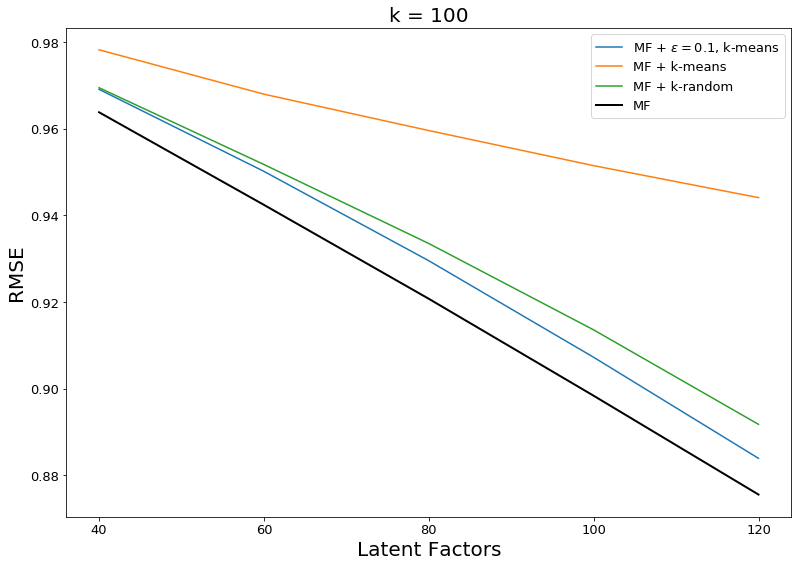

In [36]:
# Plot only one
k = 100
ep = 0.1
fig, ax = plt.subplots(figsize=(13,9))
ax.plot(L, [RESULTS_private[(l,k, ep)] for l in L], label = 'MF + $\epsilon  = ${}, k-means'.format(ep))
ax.plot(L, [RESULTS_kmeans[(l, k)] for l in L], label = 'MF + k-means')
ax.plot(L, [RESULTS_random[(l, k)] for l in L], label = 'MF + k-random')
ax.plot(L, [RESULTS_FULL[l] for l in L], label = 'MF', color = 'black', linewidth=2)
ax.legend(fontsize = 13)
ax.set_xticks(L)
ax.set_xlabel('Latent Factors', fontsize = 20)
ax.set_ylabel('RMSE', fontsize = 20)
ax.set_title('k = {}'.format(k), fontsize = 20)
ax.xaxis.set_tick_params(labelsize=13)
ax.yaxis.set_tick_params(labelsize=13)

#plt.savefig('exp2/figures/RMSEvsLatent_k100.pdf')
plt.show()



 ### <span style="color:blue"> RMSE vs k for different algorithms</span>

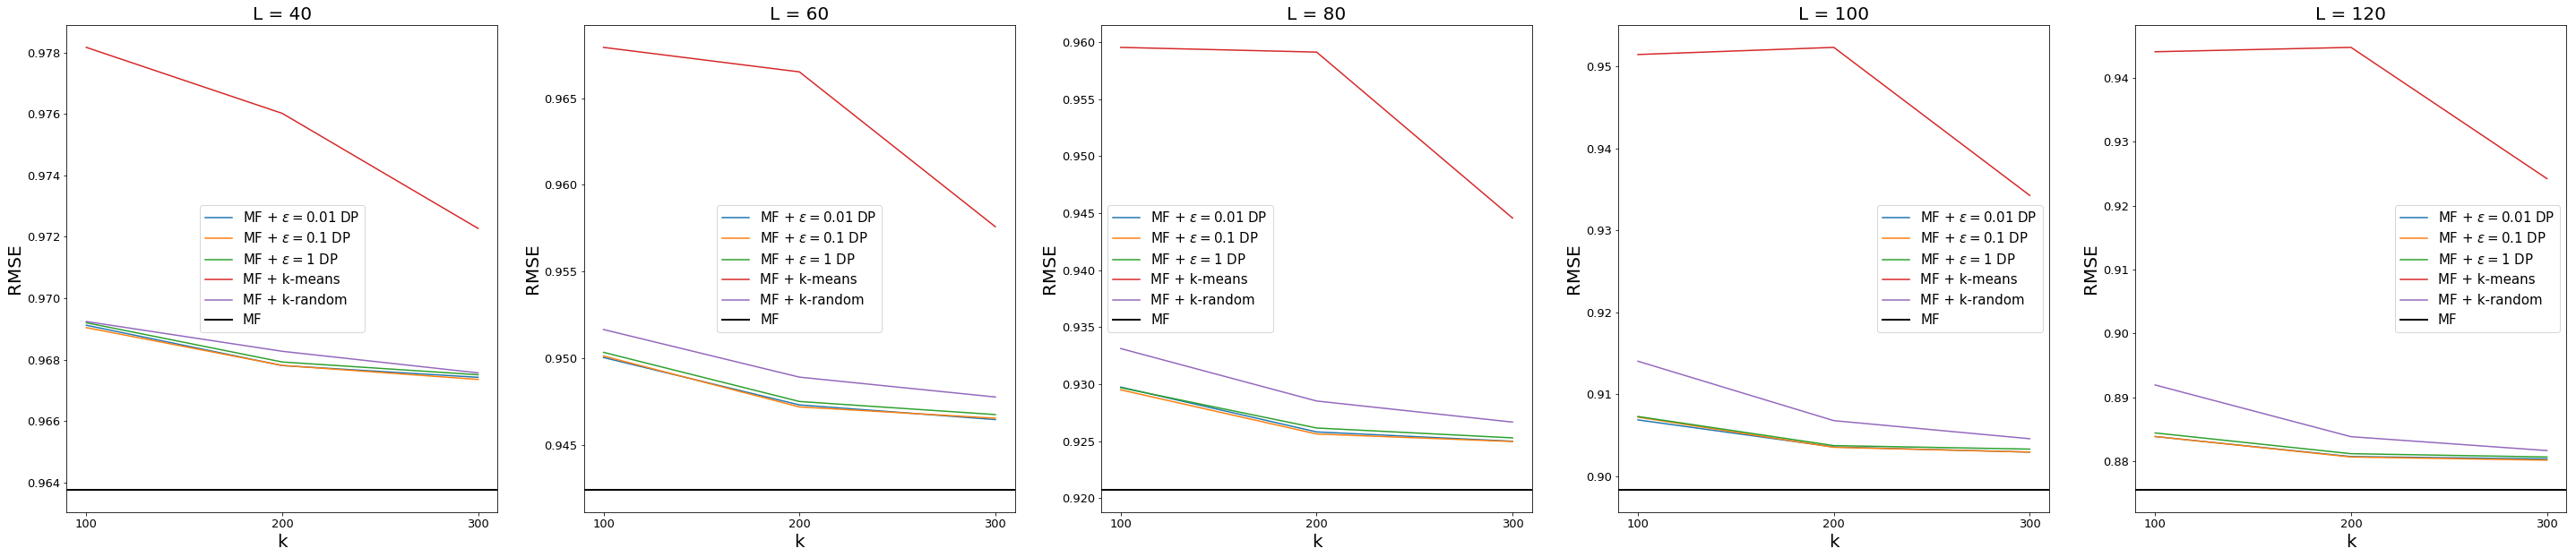

In [86]:
fig, axs = plt.subplots(1,len(L), figsize=(50, 10))

for i in range(len(L)):
    for ep in epsilons:
        axs[i].plot(ks, [RESULTS_private[(L[i],k, ep)] for k in ks], label = 'MF + $\epsilon  = ${} DP'.format(ep))
    axs[i].plot(ks, [RESULTS_kmeans[(L[i], k)] for k in ks], label = 'MF + k-means')
    axs[i].plot(ks, [RESULTS_random[(L[i], k)] for k in ks], label = 'MF + k-random')
    axs[i].axhline(RESULTS_FULL[L[i]], label = 'MF', color = 'black', linewidth=2)
    axs[i].legend(fontsize = 15)
    axs[i].set_xticks(ks)
    axs[i].set_xlabel('k', fontsize = 20)
    axs[i].set_ylabel('RMSE', fontsize = 20)
    axs[i].set_title('L = {}'.format(L[i]), fontsize = 20)
    axs[i].xaxis.set_tick_params(labelsize=13)
    axs[i].yaxis.set_tick_params(labelsize=13)

plt.savefig('exp2/figures/RMSEvsK_diffLat.pdf')
plt.show()



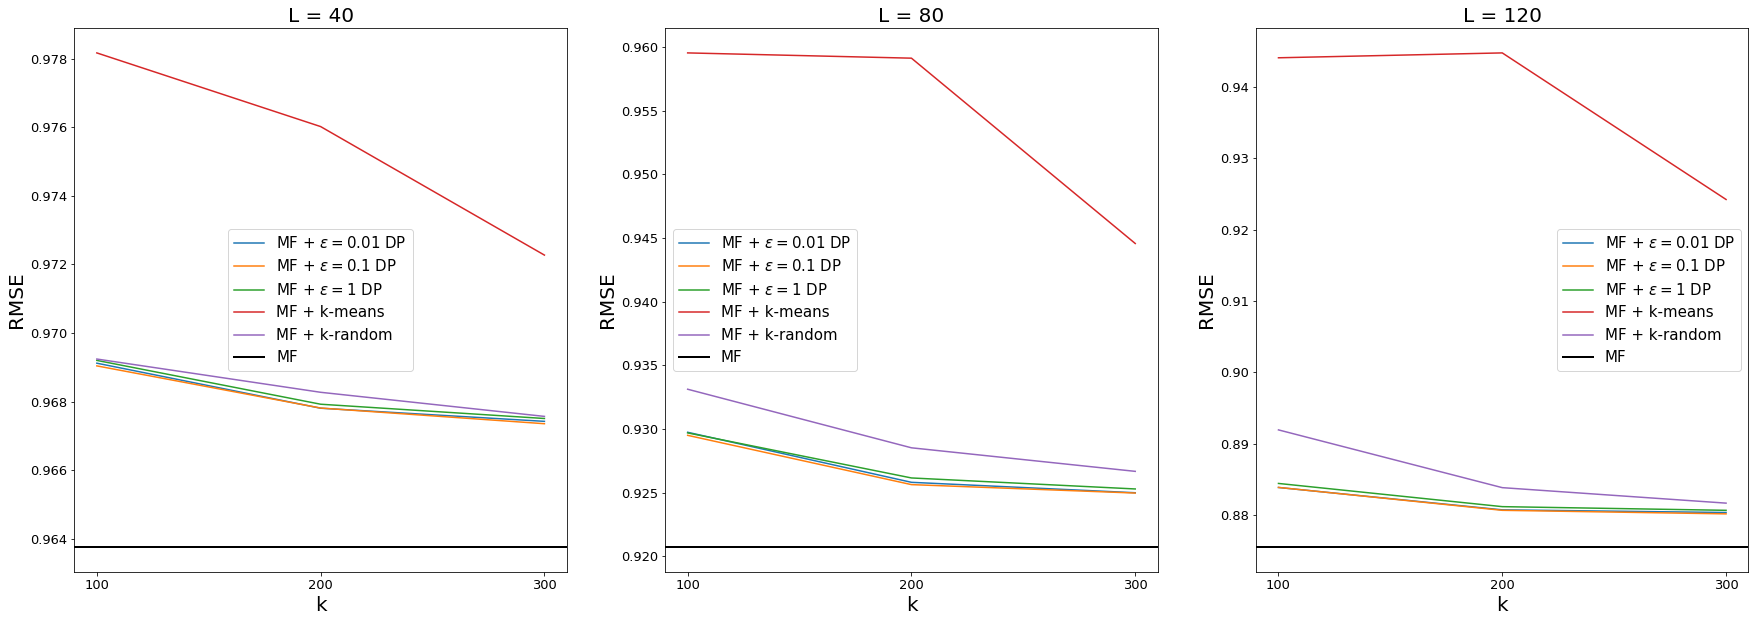

In [89]:
fig, axs = plt.subplots(1,3, figsize=(30, 10))

for i in range(3):
    for ep in epsilons:
        axs[i].plot(ks, [RESULTS_private[(L[2*i],k, ep)] for k in ks], label = 'MF + $\epsilon  = ${} DP'.format(ep))
    axs[i].plot(ks, [RESULTS_kmeans[(L[2*i], k)] for k in ks], label = 'MF + k-means')
    axs[i].plot(ks, [RESULTS_random[(L[2*i], k)] for k in ks], label = 'MF + k-random')
    axs[i].axhline(RESULTS_FULL[L[2*i]], label = 'MF', color = 'black', linewidth=2)
    axs[i].legend(fontsize = 15)
    axs[i].set_xticks(ks)
    axs[i].set_xlabel('k', fontsize = 20)
    axs[i].set_ylabel('RMSE', fontsize = 20)
    axs[i].set_title('L = {}'.format(L[2*i]), fontsize = 20)
    axs[i].xaxis.set_tick_params(labelsize=13)
    axs[i].yaxis.set_tick_params(labelsize=13)

plt.savefig('exp2/figures/RMSEvsK_diffLat2.pdf')
plt.show()



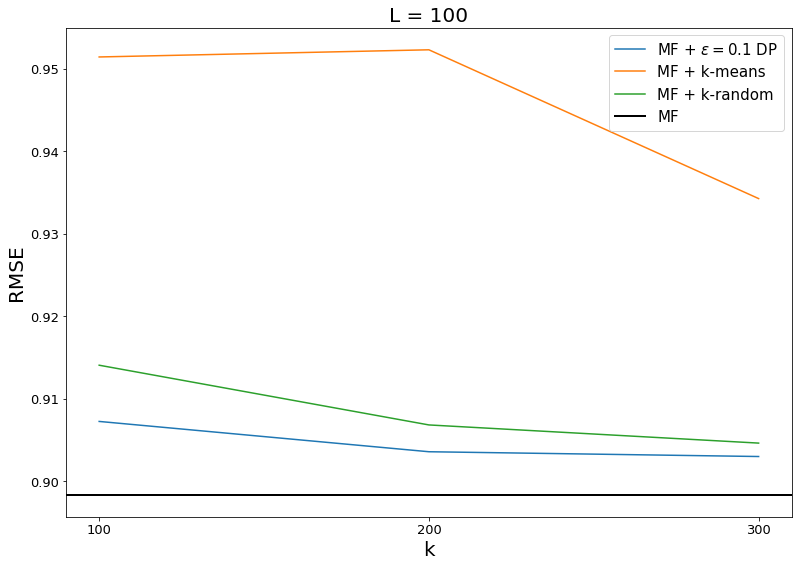

In [87]:
l = 100
ep = 0.1
fig, ax = plt.subplots(figsize=(13,9))

ax.plot(ks, [RESULTS_private[(l,k, ep)] for k in ks], label = 'MF + $\epsilon  = ${} DP'.format(ep))
ax.plot(ks, [RESULTS_kmeans[(l, k)] for k in ks], label = 'MF + k-means')
ax.plot(ks, [RESULTS_random[(l, k)] for k in ks], label = 'MF + k-random')
ax.axhline(RESULTS_FULL[l], label = 'MF', color = 'black', linewidth =2)
ax.legend(fontsize = 15)

ax.set_xlabel('k', fontsize = 20)
ax.set_xticks(ks)
ax.set_ylabel('RMSE', fontsize = 20)
ax.set_title('L = {}'.format(l), fontsize = 20)
ax.xaxis.set_tick_params(labelsize=13)
ax.yaxis.set_tick_params(labelsize=13)

plt.savefig('exp2/figures/RMSEvsK_lat100.pdf')
plt.show()



 ### <span style="color:blue"> RMSE vs LF, k=100, non-private</span>

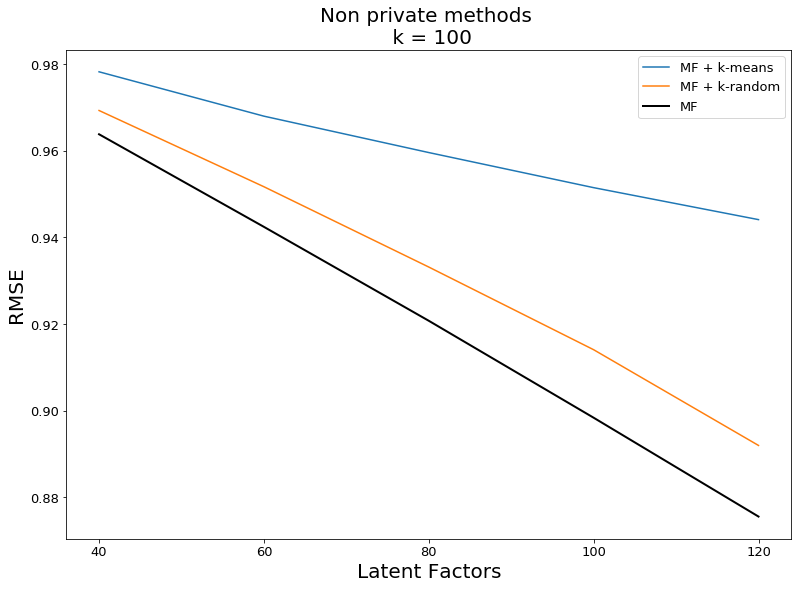

In [9]:
# Plot only one
k = 100

fig, ax = plt.subplots(figsize=(13,9))

ax.plot(L, [RESULTS_kmeans[(l, k)] for l in L], label = 'MF + k-means')
ax.plot(L, [RESULTS_random[(l, k)] for l in L], label = 'MF + k-random')
ax.plot(L, [RESULTS_FULL[l] for l in L], label = 'MF', color = 'black', linewidth=2)
ax.legend(fontsize = 13)
ax.set_xticks(L)
ax.set_xlabel('Latent Factors', fontsize = 20)
ax.set_ylabel('RMSE', fontsize = 20)
ax.set_title('Non private methods \n k = {}'.format(k), fontsize = 20)
ax.xaxis.set_tick_params(labelsize=13)
ax.yaxis.set_tick_params(labelsize=13)

plt.savefig('exp2/figures/RMSEvsLatent_k100_Nonprivate1.pdf')
plt.show()



 ### <span style="color:blue"> RMSE vs LF, k=100, non-private</span>

In [ ]:
l = 100
ep = 0.1
fig, ax = plt.subplots(figsize=(13,9))

ax.plot(ks, [RESULTS_private[(l,k, ep)] for k in ks], label = 'MF + $\epsilon  = ${} DP'.format(ep))
ax.plot(ks, [RESULTS_kmeans[(l, k)] for k in ks], label = 'MF + k-means')
ax.plot(ks, [RESULTS_random[(l, k)] for k in ks], label = 'MF + k-random')
ax.axhline(RESULTS_FULL[l], label = 'MF', color = 'black', linewidth =2)
ax.legend(fontsize = 15)

ax.set_xlabel('k', fontsize = 20)
ax.set_xticks(ks)
ax.set_ylabel('RMSE', fontsize = 20)
ax.set_title('L = {}'.format(l), fontsize = 20)
ax.xaxis.set_tick_params(labelsize=13)
ax.yaxis.set_tick_params(labelsize=13)

plt.savefig('exp2/figures/RMSEvsK_lat100.pdf')
plt.show()

